In [3]:
import sys
sys.path.append('../')

from model_runner import ModelRunner
from DBPN_copied import DBPN
from custom_image_dataset import CustomImageDataset
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import torch
torch.cuda.empty_cache()
from torch import nn
from image_helper import ImageHelper
import image_patches
import os
import pandas as pd
from GaussianNoise import AddGaussianNoise

In [4]:
# DATASET_ROOT="../datasets/"
TRAIN_DATASET_NAME = "../datasets/TRAIN_Flick2k_DIV2K/"
VALIDATION_DATASET_NAME = "../datasets/VALIDATION_Flickr2K_DIV2K/"
# TRAIN_DATASET_NAME = "../datasets/set14/"
# VALIDATION_DATASET_NAME = "../datasets/Set5/"

In [5]:
PATCH_SIZE = 128 # 32 * 4
# PATCHES_PER_IMAGE_TRAIN = 20
PATCHES_PER_IMAGE_TRAIN = 30 #######
# PATCHES_PER_IMAGE_TRAIN = 50 ##
# PATCHES_PER_IMAGE_TRAIN = 4
# PATCHES_PER_IMAGE_VALIDATION = 4
PATCHES_PER_IMAGE_VALIDATION = 20 #######
# PATCHES_PER_IMAGE_VALIDATION = 1
# PATCHES_PER_IMAGE_TRAIN = 45
# PATCHES_PER_IMAGE_VALIDATION = 12 # 45 // 4

In [6]:
TRAIN_DATA_PATH = f"{TRAIN_DATASET_NAME}_{PATCH_SIZE}_{PATCH_SIZE}_number={PATCHES_PER_IMAGE_TRAIN}"
VALIDATION_DATA_PATH =  f"{VALIDATION_DATASET_NAME}_{PATCH_SIZE}_{PATCH_SIZE}_number={PATCHES_PER_IMAGE_VALIDATION}"
print('TRAIN_DATA_PATH =', TRAIN_DATA_PATH)
print('VALIDATION_DATA_PATH =', VALIDATION_DATA_PATH)

TRAIN_DATA_PATH = ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30
VALIDATION_DATA_PATH = ../datasets/VALIDATION_Flickr2K_DIV2K/_128_128_number=20


In [7]:
# image_patches.create_valid_image_patches(f"{TRAIN_DATASET_NAME}", (PATCH_SIZE, PATCH_SIZE, 3), TRAIN_DATA_PATH, PATCHES_PER_IMAGE_TRAIN)
# image_patches.create_valid_image_patches(f"{VALIDATION_DATASET_NAME}", (PATCH_SIZE, PATCH_SIZE, 3), VALIDATION_DATA_PATH, PATCHES_PER_IMAGE_VALIDATION)

In [6]:
%%time

SCALE_FACTOR=4

transform_x = transforms.Compose([
    transforms.Resize((PATCH_SIZE // SCALE_FACTOR, PATCH_SIZE // SCALE_FACTOR), interpolation=Image.BICUBIC),
    # AddGaussianNoise(0., 0.1),
])

transform_y = transforms.Compose([
    transforms.CenterCrop((PATCH_SIZE, PATCH_SIZE))
])

# Set up the data loaders
train_data_set = CustomImageDataset(
    img_dir=TRAIN_DATA_PATH, transform=transform_x, target_transform=transform_y, tensor_size=PATCH_SIZE)
validation_data_set = CustomImageDataset(
    img_dir=VALIDATION_DATA_PATH, transform=transform_x, target_transform=transform_y, tensor_size=PATCH_SIZE)

# Report split sizes
print('Training set has {} instances'.format(len(train_data_set)))
print('Validation set has {} instances'.format(len(validation_data_set)))

Creating Dataset based on folder: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30


 88%|████████▊ | 2557/2920 [00:58<00:08, 45.14it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: Out of bound read in decode_png. Probably, the input image is corrupted


100%|██████████| 2920/2920 [01:06<00:00, 43.88it/s]


Creating Dataset based on folder: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30
Creating Dataset based on folder: ../datasets/VALIDATION_Flickr2K_DIV2K/_128_128_number=20


100%|██████████| 630/630 [00:09<00:00, 67.05it/s]


Creating Dataset based on folder: ../datasets/VALIDATION_Flickr2K_DIV2K/_128_128_number=20
Training set has 87539 instances
Validation set has 12592 instances
CPU times: user 1h 12s, sys: 13 s, total: 1h 25s
Wall time: 1min 22s


In [7]:
# image_helper = ImageHelper()
# image =  Image.open('../datasets/Set5/baby.png')
# image_tensor = image_helper.image_to_tensor(image)
# image_tensor = image_tensor + torch.randn(image_tensor.shape)*0.1
# image_helper.show_tensor_as_image(image_tensor)

In [8]:
%%time

# https://towardsdatascience.com/7-tips-for-squeezing-maximum-performance-from-pytorch-ca4a40951259
pin_memory = False
batch_size = round(1*(2**6))

train_dataloader = DataLoader(train_data_set, batch_size=batch_size, shuffle=True, pin_memory=pin_memory)
validation_dataloader = DataLoader(validation_data_set, batch_size=batch_size, pin_memory=pin_memory)

CPU times: user 1.27 s, sys: 276 ms, total: 1.55 s
Wall time: 1.55 s


In [9]:
# image_helper = ImageHelper()
# i = 0
# for x, y in train_dataloader:
#     i += 1
#     if i > 2:
#         break
#     image_helper.show_tensor_as_image(x[0])
#     image_helper.show_tensor_as_image(y[0])
#     print(x.shape)
#     print(y.shape)
#     break

In [8]:
# The learning rate is initialized to 1e − 4 for all layers and decrease by a factor of 10 for every 5 × 105 iterations for total 106 iterations.
lr = 5e-3
model_betas = (0.9, 0.999)
device = torch.device('cuda:0')

# Total number of epochs
epochs = 25

model = DBPN(num_channels=3, base_filter=64,  feat = 256, num_stages=7, scale_factor=4).to(device)
model_runner = ModelRunner()

# For optimization, we use Adam with momentum to 0.9 and weight decay to 1e−4.
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=model_betas, weight_decay=1e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
#                               T_max = epochs, # Maximum number of iterations.
#                              eta_min = 1e-6) # Minimum learning rate.

In [11]:
%%time
model_runner.train(
    model=model,
    train_dataloader=train_dataloader,
    validation_dataloader=validation_dataloader,
    optimizer=optimizer,
    epochs=epochs,
    scheduler=None,
    loss_fn=nn.MSELoss(),
    save_file_path='./DBPN-real-run-medium-dataset-no-noise-cuda-0.txt'
)


epoch 0
-------------------------------


Training on 87539 samples...
Batch size: 64
Number of batches: 1368


  0%|          | 0/1368 [00:00<?, ?it/s]/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 1368/1368 [07:08<00:00,  3.19it/s]


Training Error: 
 Avg loss: 15413184222225175150592.000000 



100%|██████████| 197/197 [00:23<00:00,  8.38it/s]


Validation Error: 
 Avg loss: 6317425014954894336.000000 

Epoch: 0
Time: 454.6230661869049
Learning rate: 0.005
Train loss: 1.5413184222225175e+22
Validation loss: 6.317425014954894e+18
Elapsed time: 454.6231632232666

epoch 1
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:08<00:00,  3.19it/s]


Training Error: 
 Avg loss: 3144514600683544064.000000 



100%|██████████| 197/197 [00:23<00:00,  8.38it/s]


Validation Error: 
 Avg loss: 1614384021814330624.000000 

Epoch: 1
Time: 454.5651354789734
Learning rate: 0.005
Train loss: 3.144514600683544e+18
Validation loss: 1.6143840218143306e+18
Elapsed time: 454.56523156166077

epoch 2
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:08<00:00,  3.19it/s]


Training Error: 
 Avg loss: 1099170743304644992.000000 



100%|██████████| 197/197 [00:23<00:00,  8.38it/s]


Validation Error: 
 Avg loss: 937424305064174080.000000 

Epoch: 2
Time: 454.5558114051819
Learning rate: 0.005
Train loss: 1.099170743304645e+18
Validation loss: 9.374243050641741e+17
Elapsed time: 454.555903673172

epoch 3
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:08<00:00,  3.19it/s]


Training Error: 
 Avg loss: 595317527596206080.000000 



100%|██████████| 197/197 [00:23<00:00,  8.38it/s]


Validation Error: 
 Avg loss: 418191148667996928.000000 

Epoch: 3
Time: 454.22042870521545
Learning rate: 0.005
Train loss: 5.953175275962061e+17
Validation loss: 4.181911486679969e+17
Elapsed time: 454.2205214500427

epoch 4
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:08<00:00,  3.19it/s]


Training Error: 
 Avg loss: 369571120013127680.000000 



100%|██████████| 197/197 [00:23<00:00,  8.39it/s]


Validation Error: 
 Avg loss: 252404335207593952.000000 

Epoch: 4
Time: 454.1823675632477
Learning rate: 0.005
Train loss: 3.695711200131277e+17
Validation loss: 2.5240433520759395e+17
Elapsed time: 454.18245816230774

epoch 5
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:08<00:00,  3.20it/s]


Training Error: 
 Avg loss: 247023468329011264.000000 



100%|██████████| 197/197 [00:23<00:00,  8.39it/s]


Validation Error: 
 Avg loss: 163455887573232864.000000 

Epoch: 5
Time: 454.0742287635803
Learning rate: 0.005
Train loss: 2.4702346832901126e+17
Validation loss: 1.6345588757323286e+17
Elapsed time: 454.0743181705475

epoch 6
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:08<00:00,  3.19it/s]


Training Error: 
 Avg loss: 171449875600115968.000000 



100%|██████████| 197/197 [00:23<00:00,  8.38it/s]


Validation Error: 
 Avg loss: 117232404613921648.000000 

Epoch: 6
Time: 454.20309615135193
Learning rate: 0.005
Train loss: 1.7144987560011597e+17
Validation loss: 1.1723240461392165e+17
Elapsed time: 454.20318818092346

epoch 7
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:08<00:00,  3.19it/s]


Training Error: 
 Avg loss: 120938859175977776.000000 



100%|██████████| 197/197 [00:23<00:00,  8.38it/s]


Validation Error: 
 Avg loss: 140396962810744816.000000 

Epoch: 7
Time: 454.3927261829376
Learning rate: 0.005
Train loss: 1.2093885917597778e+17
Validation loss: 1.4039696281074482e+17
Elapsed time: 454.3928167819977

epoch 8
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:08<00:00,  3.20it/s]


Training Error: 
 Avg loss: 102855529433429952.000000 



100%|██████████| 197/197 [00:23<00:00,  8.39it/s]


Validation Error: 
 Avg loss: 70538789171131640.000000 

Epoch: 8
Time: 454.09364128112793
Learning rate: 0.005
Train loss: 1.0285552943342995e+17
Validation loss: 7.053878917113164e+16
Elapsed time: 454.093736410141

epoch 9
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:08<00:00,  3.19it/s]


Training Error: 
 Avg loss: 57667737452352376.000000 



100%|██████████| 197/197 [00:23<00:00,  8.38it/s]


Validation Error: 
 Avg loss: 31323968286630344.000000 

Epoch: 9
Time: 454.22915863990784
Learning rate: 0.005
Train loss: 5.7667737452352376e+16
Validation loss: 3.1323968286630344e+16
Elapsed time: 454.22924280166626

epoch 10
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:08<00:00,  3.19it/s]


Training Error: 
 Avg loss: 51340807133080808.000000 



100%|██████████| 197/197 [00:23<00:00,  8.38it/s]


Validation Error: 
 Avg loss: 22181633205575640.000000 

Epoch: 10
Time: 454.3729283809662
Learning rate: 0.005
Train loss: 5.134080713308081e+16
Validation loss: 2.218163320557564e+16
Elapsed time: 454.3730127811432

epoch 11
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:08<00:00,  3.19it/s]


Training Error: 
 Avg loss: 27424370454589128.000000 



100%|██████████| 197/197 [00:23<00:00,  8.38it/s]


Validation Error: 
 Avg loss: 16325537271370040.000000 

Epoch: 11
Time: 454.1938638687134
Learning rate: 0.005
Train loss: 2.742437045458913e+16
Validation loss: 1.632553727137004e+16
Elapsed time: 454.1939549446106

epoch 12
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:08<00:00,  3.20it/s]


Training Error: 
 Avg loss: 21922214553218760.000000 



100%|██████████| 197/197 [00:23<00:00,  8.39it/s]


Validation Error: 
 Avg loss: 7770429650769764.000000 

Epoch: 12
Time: 454.067480802536
Learning rate: 0.005
Train loss: 2.192221455321876e+16
Validation loss: 7770429650769764.0
Elapsed time: 454.0675754547119

epoch 13
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:08<00:00,  3.20it/s]


Training Error: 
 Avg loss: 13472123133109230.000000 



100%|██████████| 197/197 [00:23<00:00,  8.39it/s]


Validation Error: 
 Avg loss: 4585616531335241.000000 

Epoch: 13
Time: 454.0983211994171
Learning rate: 0.005
Train loss: 1.347212313310923e+16
Validation loss: 4585616531335241.0
Elapsed time: 454.0984182357788

epoch 14
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:08<00:00,  3.19it/s]


Training Error: 
 Avg loss: 50111075657093816.000000 



100%|██████████| 197/197 [00:23<00:00,  8.38it/s]


Validation Error: 
 Avg loss: 18629893406204360.000000 

Epoch: 14
Time: 454.23883295059204
Learning rate: 0.005
Train loss: 5.0111075657093816e+16
Validation loss: 1.862989340620436e+16
Elapsed time: 454.2389266490936

epoch 15
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:08<00:00,  3.20it/s]


Training Error: 
 Avg loss: 6773492261972746.000000 



100%|██████████| 197/197 [00:23<00:00,  8.38it/s]


Validation Error: 
 Avg loss: 3841238904599962.500000 

Epoch: 15
Time: 454.1536250114441
Learning rate: 0.005
Train loss: 6773492261972746.0
Validation loss: 3841238904599962.5
Elapsed time: 454.1537253856659

epoch 16
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:07<00:00,  3.20it/s]


Training Error: 
 Avg loss: 3836064098257722.500000 



100%|██████████| 197/197 [00:23<00:00,  8.39it/s]


Validation Error: 
 Avg loss: 1948623469244021.000000 

Epoch: 16
Time: 453.89517760276794
Learning rate: 0.005
Train loss: 3836064098257722.5
Validation loss: 1948623469244021.0
Elapsed time: 453.8952808380127

epoch 17
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:08<00:00,  3.19it/s]


Training Error: 
 Avg loss: 2629309419194428.000000 



100%|██████████| 197/197 [00:23<00:00,  8.39it/s]


Validation Error: 
 Avg loss: 1142168076560124.000000 

Epoch: 17
Time: 454.4784038066864
Learning rate: 0.005
Train loss: 2629309419194428.0
Validation loss: 1142168076560124.0
Elapsed time: 454.4784791469574

epoch 18
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:08<00:00,  3.19it/s]


Training Error: 
 Avg loss: 2096891637549020.000000 



100%|██████████| 197/197 [00:23<00:00,  8.38it/s]


Validation Error: 
 Avg loss: 759869248787908.250000 

Epoch: 18
Time: 454.32352662086487
Learning rate: 0.005
Train loss: 2096891637549020.0
Validation loss: 759869248787908.2
Elapsed time: 454.32360792160034

epoch 19
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:08<00:00,  3.20it/s]


Training Error: 
 Avg loss: 1180310621296819.750000 



100%|██████████| 197/197 [00:23<00:00,  8.39it/s]


Validation Error: 
 Avg loss: 483718903277807.125000 

Epoch: 19
Time: 454.1045198440552
Learning rate: 0.005
Train loss: 1180310621296819.8
Validation loss: 483718903277807.1
Elapsed time: 454.10459899902344

epoch 20
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:08<00:00,  3.19it/s]


Training Error: 
 Avg loss: 773945474737038.250000 



100%|██████████| 197/197 [00:23<00:00,  8.38it/s]


Validation Error: 
 Avg loss: 254080511196435.500000 

Epoch: 20
Time: 454.1784384250641
Learning rate: 0.005
Train loss: 773945474737038.2
Validation loss: 254080511196435.5
Elapsed time: 454.1785216331482

epoch 21
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:08<00:00,  3.19it/s]


Training Error: 
 Avg loss: 1906817064367815168.000000 



100%|██████████| 197/197 [00:23<00:00,  8.39it/s]


Validation Error: 
 Avg loss: 24687446422019140.000000 

Epoch: 21
Time: 454.17096042633057
Learning rate: 0.005
Train loss: 1.9068170643678152e+18
Validation loss: 2.468744642201914e+16
Elapsed time: 454.1710548400879

epoch 22
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:08<00:00,  3.19it/s]


Training Error: 
 Avg loss: 14197665916073828.000000 



100%|██████████| 197/197 [00:23<00:00,  8.39it/s]


Validation Error: 
 Avg loss: 8828291831990719.000000 

Epoch: 22
Time: 454.3114607334137
Learning rate: 0.005
Train loss: 1.4197665916073828e+16
Validation loss: 8828291831990719.0
Elapsed time: 454.3115453720093

epoch 23
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:08<00:00,  3.19it/s]


Training Error: 
 Avg loss: 6653302600430981.000000 



100%|██████████| 197/197 [00:23<00:00,  8.39it/s]


Validation Error: 
 Avg loss: 5046496395519491.000000 

Epoch: 23
Time: 454.3573594093323
Learning rate: 0.005
Train loss: 6653302600430981.0
Validation loss: 5046496395519491.0
Elapsed time: 454.3574411869049

epoch 24
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:08<00:00,  3.19it/s]


Training Error: 
 Avg loss: 4109428391166431.000000 



100%|██████████| 197/197 [00:23<00:00,  8.39it/s]

Validation Error: 
 Avg loss: 3285608194760246.500000 

Epoch: 24
Time: 454.27594542503357
Learning rate: 0.005
Train loss: 4109428391166431.0
Validation loss: 3285608194760246.5
Elapsed time: 454.2760238647461
CPU times: user 3h 8min 14s, sys: 1min 25s, total: 3h 9min 40s
Wall time: 3h 9min 16s


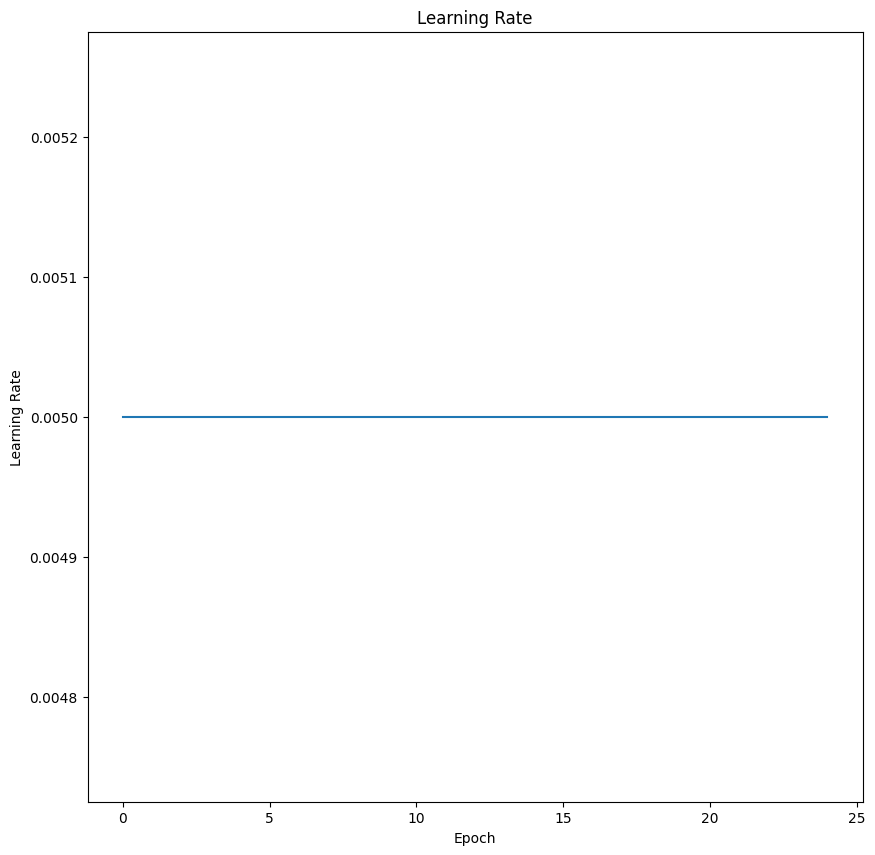

In [14]:
model_runner.plot_lr_from_df()

In [15]:
# model_runner.save_model_df('../results/dbpn/dataframes/DBPN-real-run-medium-dataset-lr-times-50-epoch=0-24.csv')
# model_runner.save_model_weights(model, '../results/dbpn/dataframes/DBPN-real-run-medium-dataset-lr-times-50-epoch=0-24.pth')

In [16]:
# df = model_runner.load_df('../results/dbpn/dataframes/DBPN-real-run-medium-dataset-lr-times-50-epoch=0-24.csv')
# df
model_runner.get_model_df()

,epoch,time,lr,train_loss,validation_loss
0,0,454.623066,0.005,1.541318e+22,6.317425e+18
1,1,454.565135,0.005,3.144515e+18,1.614384e+18
2,2,454.555811,0.005,1.099171e+18,9.374243e+17
3,3,454.220428,0.005,5.953175e+17,4.181911e+17
4,4,454.182367,0.005,3.695711e+17,2.524043e+17
5,5,454.074228,0.005,2.470235e+17,1.634559e+17
6,6,454.203095,0.005,1.714499e+17,1.172324e+17
7,7,454.392725,0.005,1.209389e+17,1.403970e+17
8,8,454.093641,0.005,1.028555e+17,7.053879e+16
9,9,454.229158,0.005,5.766774e+16,3.132397e+16


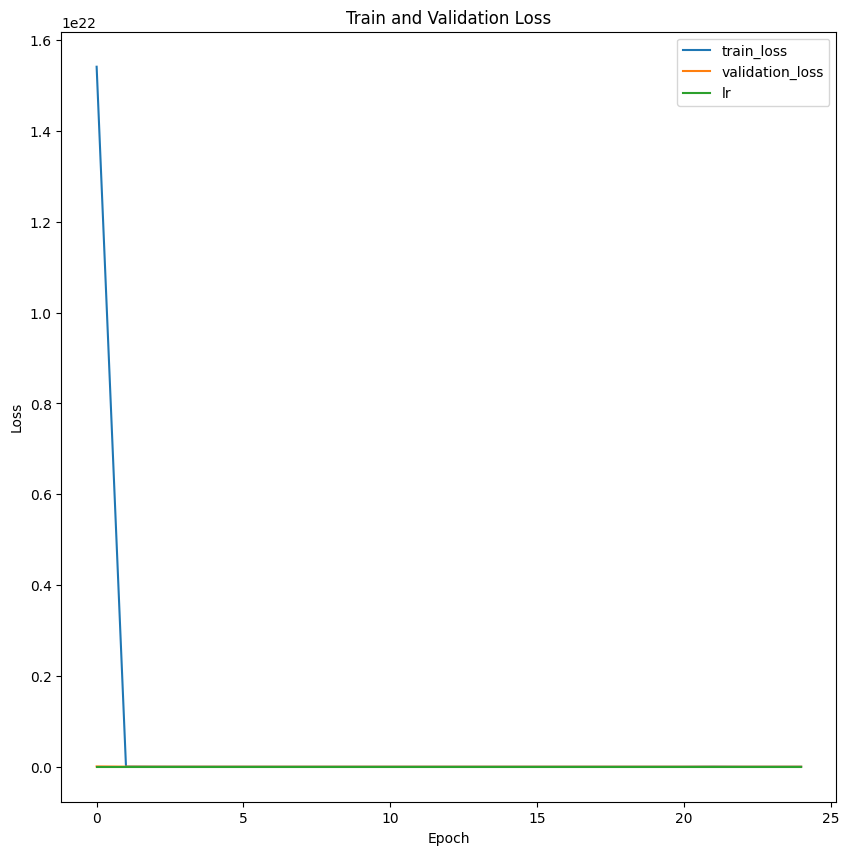

In [17]:
model_runner.plot_train_validation_loss_from_df()

/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


should_upsample MUST ONLY BE `TRUE` for SRCNN


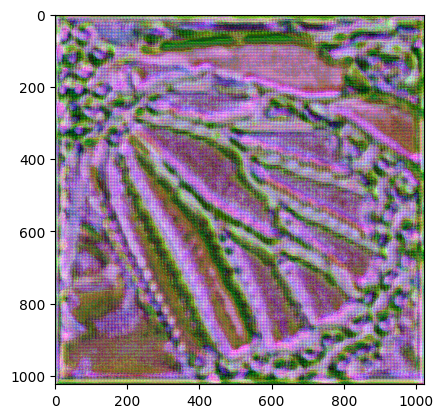

In [18]:
image_helper = ImageHelper()
image_helper.apply_model_to_image_and_show(
    model=model,
    image=f"../datasets/Set5/butterfly.png",
    downsample_factor=4,
    unsqueeze=True
)

In [19]:
model_runner = ModelRunner(device=device)
model_runner.compare_models(
    [
        {"name": "DBPN", "model": model,
                               "input_transform":lambda input: transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Resize(
                                    (input.size[1] // 4, input.size[0] // 4), interpolation=Image.BICUBIC),
                                ])(input),
                                "should_only_downsampple": True, "scale":4, "unsqueeze": True },
    ],
    f"../datasets/BSDS100/", scale=4
)

0it [00:00, ?it/s]/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:61: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
100it [00:03, 32.91it/s]
100it [00:01, 94.95it/s]


,PSNR,SSIM
DBPN,-150.240128,8.621222e-18
Bicubic,23.045410,6.328681e-01


In [29]:
model_runner = ModelRunner(device=device)
model_runner.compare_models(
    [
        {"name": "DBPN", "model": model,
                               "input_transform":lambda input: transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Resize(
                                    (input.size[1] // 4, input.size[0] // 4), interpolation=Image.BICUBIC),
                                ])(input),
                                "should_only_downsampple": True, "scale":4, "unsqueeze": True },
    ],
    f"../datasets/BSDS100/", scale=4
)

0it [00:00, ?it/s]/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:61: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `P

,PSNR,SSIM
DBPN,24.850704,0.653421
Bicubic,23.045410,0.632868


In [9]:
model_2 = DBPN(num_channels=3, base_filter=64,  feat = 256, num_stages=7, scale_factor=4).to(device)
model_2.load_state_dict(torch.load('../results/dbpn/dataframes/DBPN-real-run-medium-dataset-lr-times-50-epoch=0-24.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [11]:
model_runner.compare_models(
    [
        {"name": "DBPN", "model": model_2,
                               "input_transform":lambda input: transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Resize(
                                    (input.size[1] // 4, input.size[0] // 4), interpolation=Image.BICUBIC),
                                ])(input),
                                "should_only_downsampple": True, "scale":4, "unsqueeze": True },
    ],
    f"../datasets/BSDS100/", scale=4
)

0it [00:00, ?it/s]/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:61: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
100it [00:02, 34.28it/s]
100it [00:00, 100.20it/s]


,PSNR,SSIM
DBPN,-150.240128,8.621222e-18
Bicubic,23.045410,6.328681e-01


should_upsample MUST ONLY BE `TRUE` for SRCNN


/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


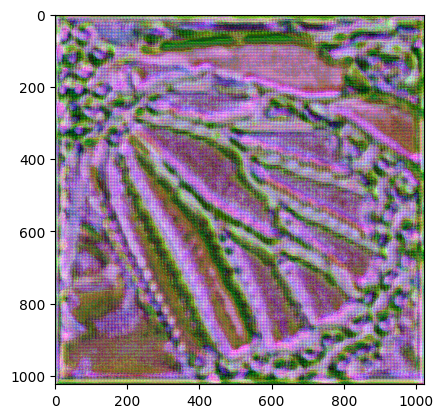

In [10]:
image_helper = ImageHelper()
image_helper.apply_model_to_image_and_show(
    model=model_2,
    image=f"../datasets/Set5/butterfly.png",
    downsample_factor=4,
    unsqueeze=True
)